# We will use SVC to predict different diagnoses

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import numpy as np

In [4]:
df = pd.read_csv("df.csv")
df.head()

,column_3,column_20,column_11,column_16,column_22,column_10,column_26,column_19,column_13,column_12,...,column_7,column_5,column_21,column_29,column_15,column_9,column_6,column_24,column_17,column_18
0,18,0.0,3.5,31.0,126.0,24.18,5157.0,100.0000,35.00,24.00,...,1.116260,0,21.0,14617.0,17.0,251.7,1,1.5,2.0,7.0
1,10,5.0,1.0,37.0,240.0,13.30,6451.0,12.5000,22.00,15.00,...,NaN,0,30.0,18691.0,26.0,159.7,0,1.5,4.0,1.0
2,16,15.0,1.5,40.0,83.0,34.04,6832.0,50.0000,NaN,5.67,...,1.280900,0,44.0,24193.0,30.0,334.1,0,1.5,6.0,6.0
3,12,1.0,4.0,21.0,144.0,27.37,5266.0,100.0000,35.33,23.33,...,0.937913,0,24.0,15759.0,25.0,287.7,1,1.5,2.0,5.0
4,9,12.0,0.0,32.0,66.0,19.88,7331.0,-28.5714,12.33,8.33,...,1.360140,0,47.0,16014.0,30.0,203.7,1,1.5,3.0,-2.0


# EDA

In [5]:
df.shape

(1403, 32)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403 entries, 0 to 1402
Data columns (total 32 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   column_3   1403 non-null   int64  
 1   column_20  1396 non-null   float64
 2   column_11  1392 non-null   float64
 3   column_16  1391 non-null   float64
 4   column_22  1361 non-null   float64
 5   column_10  1403 non-null   float64
 6   column_26  1150 non-null   float64
 7   column_19  1380 non-null   float64
 8   column_13  1385 non-null   float64
 9   column_12  1399 non-null   float64
 10  column_14  1401 non-null   float64
 11  target     1403 non-null   int64  
 12  column_8   1403 non-null   float64
 13  column_31  1341 non-null   float64
 14  column_27  1296 non-null   float64
 15  column_25  1261 non-null   float64
 16  column_1   1403 non-null   float64
 17  column_4   1403 non-null   int64  
 18  column_2   1403 non-null   int64  
 19  column_28  1082 non-null   float64
 20  column_2

In [7]:
print(df.isna().sum()) #different NaN

column_3       0
column_20      7
column_11     11
column_16     12
column_22     42
column_10      0
column_26    253
column_19     23
column_13     18
column_12      4
column_14      2
target         0
column_8       0
column_31     62
column_27    107
column_25    142
column_1       0
column_4       0
column_2       0
column_28    321
column_23      7
column_30    321
column_7     553
column_5       0
column_21    662
column_29    321
column_15      1
column_9       0
column_6       0
column_24    120
column_17     12
column_18     13
dtype: int64


In [8]:
print(df["target"].isna().sum()) # no Nan in target

0


In [9]:
#plot of target value
def plot_value_counts(df, target_column, colors) -> None:
    """
    Creates a bar plot of value counts for a specific column in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame from which to extract the data.
    target_column (str): The name of the target column in the DataFrame.
    colors (dict): A dictionary mapping target values to colors.

    Example:
    >>> df = pd.DataFrame({'target': [1, 2, 2, 0, 1, 2, 0, 0, 1, 1]})
    >>> colors = {0:'green', 1:'orange', 2:'red'}
    >>> plot_value_counts(df, 'target', colors)
    """

    # Calculate the value counts
    value_counts = df[target_column].value_counts()

    # Create a bar plot with different colors for each bar
    plt.bar(value_counts.index, value_counts.values, color=[colors[i] for i in value_counts.index])

    # Add the numbers above each column
    for i in value_counts.index:
        plt.text(i, max(value_counts.values), str(value_counts[i]), ha='center', va='bottom')

    # Set the x-axis limits
    plt.xticks(value_counts.index)
    plt.xlabel("target")
    plt.ylabel("count")
    plt.title("Target distribution")

    # Show the plot
    plt.show()


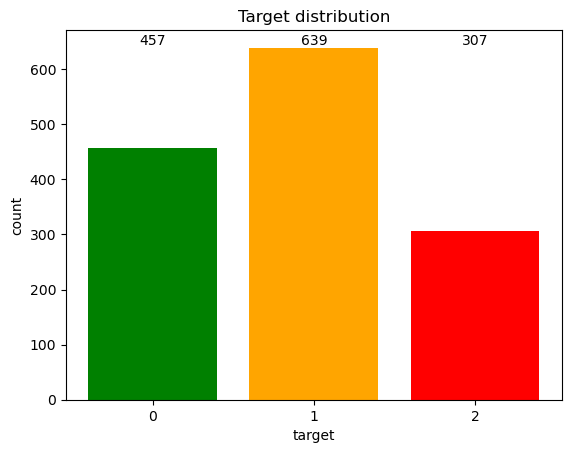

In [10]:
plot_value_counts(df, "target", colors = {0:'green', 1:'orange', 2:'red'})

## Preprocessing 

In [11]:
y = df["target"]
X = df.drop("target", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Data imputation for missing values

In [12]:
imputer=SimpleImputer(strategy="mean")

In [13]:
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

## Standardization

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test =scaler.transform(X_test)

## Feature selection: random forest

In [15]:
def plot_feature_importances(X_train, y_train, n_estimators=35) -> pd.DataFrame:
    """
    Trains a RandomForestClassifier and plots the feature importances.

    Parameters:
    X_train (pd.DataFrame): The input features for training.
    y_train (pd.Series): The target output for training.
    n_estimators (int, optional): The number of trees in the forest. Defaults to 35.

    Returns:
    final_df (pd.DataFrame): A DataFrame containing the features and their corresponding importances.
    """
    # Train the model
    model = RandomForestClassifier(n_estimators=n_estimators)
    model.fit(X_train, y_train)

    # Get feature importances
    importances = model.feature_importances_

    # Create a DataFrame with feature numbers and their corresponding importances
    final_df = pd.DataFrame({'Features': range(len(importances)), 'Importances': importances})

    # Set "Features" as index
    final_df.set_index("Features", inplace=True)

    # Sort the DataFrame by "Importances"
    final_df = final_df.sort_values("Importances")

    # Plot the DataFrame
    final_df.plot.bar(color = "teal")
    plt.show()

    # Return the DataFrame
    return final_df


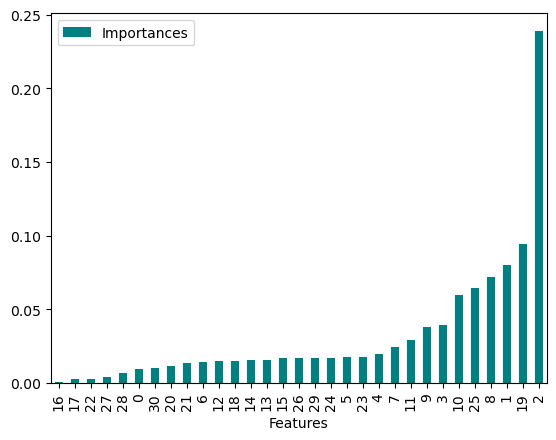

          Importances
Features             
16           0.000893
17           0.002685
22           0.002794
27           0.003785
28           0.006802
0            0.009206
30           0.009938
20           0.011326
21           0.013496
6            0.014064
12           0.015061
18           0.015225
14           0.015496
13           0.015674
15           0.016762
26           0.016763
29           0.016872
24           0.017056
5            0.017312
23           0.017797
4            0.019814
7            0.024569
11           0.029328
9            0.038331
3            0.039297
10           0.059814
25           0.064767
8            0.071646
1            0.079964
19           0.094525
2            0.238938


In [16]:
importances_df = plot_feature_importances(X_train, y_train)
print(importances_df)

**it seems that feature 2 is very important in defining our model**

## VIF

In [17]:
#VIF check & delete autocorrelated features:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
vif["features"] = range(X_train.shape[1])
vif.round(1)

,VIF Factor,features
0,1.2,0
1,3.3,1
2,6.3,2
3,4.0,3
4,1.8,4
5,35.7,5
6,2.9,6
7,6.3,7
8,15.0,8
9,11.6,9


In [20]:
#remove all features with VIF>10
to_drop_vif = vif[vif["VIF Factor"] > 10]
# Get the indices of the features to drop
to_drop_indices = to_drop_vif["features"].values

# Drop the features from X_train and X_test
X_train = np.delete(X_train, to_drop_indices, axis=1)
X_test = np.delete(X_test, to_drop_indices, axis=1)

## SVC

In [21]:
svc = SVC(probability=True)

In [22]:
# Different iperparameters to test with GridSearchCV
hyper = {'kernel':('linear', 'rbf','poly','sigmoid'), 'C':[0.1, 1, 10], 'gamma':[0.1, 1, 10]}

In [23]:
# GridSearchCV inizialization with SVC model and hyperparameters defined
clf = GridSearchCV(svc, hyper)

In [24]:
# training
best_svc = clf.fit(X_train, y_train)

In [25]:
print(best_svc.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}


In [26]:
y_pred = best_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       137
           1       0.89      0.88      0.88       201
           2       0.83      0.89      0.86        83

    accuracy                           0.89       421
   macro avg       0.88      0.89      0.89       421
weighted avg       0.89      0.89      0.89       421



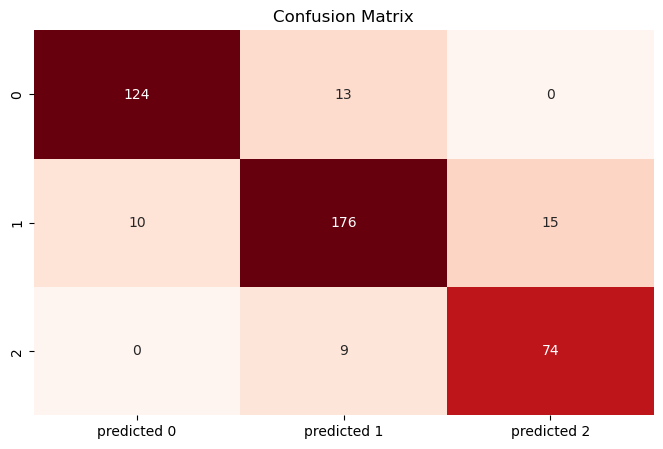

In [27]:
cm_lin = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,5))
sns.heatmap(cm_lin, annot=True, fmt="d", xticklabels=['predicted 0','predicted 1','predicted 2'], yticklabels=[0,1,2], cbar=False, cmap="Reds", vmin=0, vmax=93)
plt.title("Confusion Matrix")
plt.show()

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def plot_roc_curve(y_test, y_score, n_classes=3) -> None:
    """
    This function plots the ROC curve for each class.
    
    Parameters:
    y_test: array-like of shape (n_samples,) - True labels
    y_score: array-like of shape (n_samples,) - Target scores
    n_classes: int - Number of classes
    
    Returns:
    None
    """
    # Binarize y_test for multiclass calculation
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

    # Calculate the ROC curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Define colors for each class
    colors = ['green', 'orange', 'red']

    # Plot the ROC curve
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


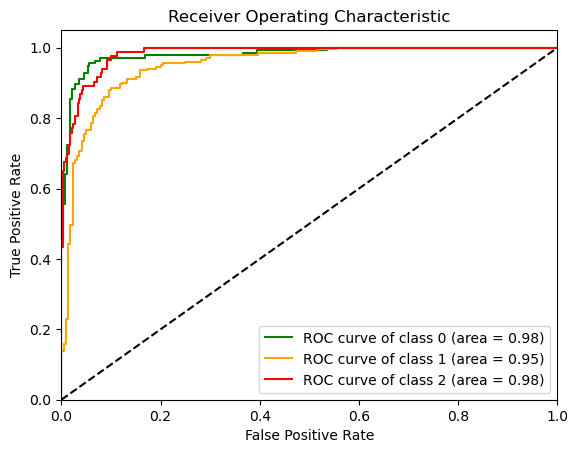

In [29]:
y_score = best_svc.predict_proba(X_test)
plot_roc_curve(y_test, y_score, n_classes=3)